## Membandingkan Regularisasi L1 & L2 pada Database MTCARS

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import pearsonr, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

### Load

In [6]:
# Load
df = pd.read_csv("D:\Datasets\mtcars.csv", delimiter=";")
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


(None,
                model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
 0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
 1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
 2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
 3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
 4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   
 
    carb  
 0     4  
 1     4  
 2     1  
 3     1  
 4     2  )

### Correlation Matrix

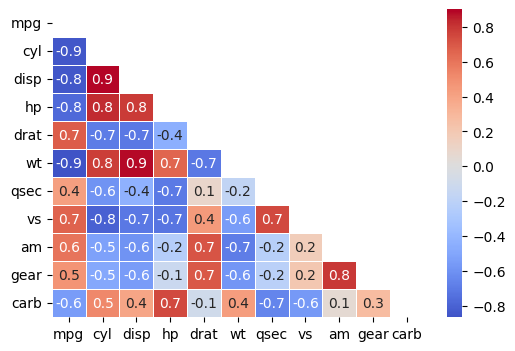

In [7]:
# Hanya memilih kolom numerik
df_numeric = df.select_dtypes(include=[np.number])

# Hitung korelasi
corr = df_numeric.corr()

# Buat mask segitiga untuk menampilkan setengah dari matriks
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".1f", center=0, linewidths=0.5)

# Tampilkan plot
plt.show()

### Feature Extraction

In [8]:
# Feature Extraction
# Definisi variabel independent (X) dan dependent (y)
X = df.drop(columns=["mpg", 'model'], axis=1)  # Fitur (predictors)
y = df["mpg"]  # Response variabel (Miles per Gallon) 

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Cek ukuran data hasil split
print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")

Ukuran X_train: (25, 10)
Ukuran X_test: (7, 10)
Ukuran y_train: (25,)
Ukuran y_test: (7,)


### Cek OLS

In [9]:
# OLS
# Tambahkan konstanta ke dalam model (intersep)
X_train_ols = sm.add_constant(X_train)  # Menambahkan kolom konstanta untuk intersep
X_test_ols = sm.add_constant(X_test)  # Untuk evaluasi nanti

# Buat model OLS
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Cetak ringkasan model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     9.804
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           9.89e-05
Time:                        17:12:55   Log-Likelihood:                -53.488
No. Observations:                  25   AIC:                             129.0
Df Residuals:                      14   BIC:                             142.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5937     30.491     -0.183      0.8

### Pemeriksaan Asumsi OLS

In [10]:
# Uji Linearitas
correlation_results = []
p_value_results = []

for col in X.columns:
    corr, p_value = pearsonr(y, X[col])
    correlation_results.append(corr)
    p_value_results.append(p_value)

# Gabungkan hasil dalam DataFrame
cor_test_results = pd.DataFrame({
    "Variable": X.columns,
    "Correlation": correlation_results,
    "p-value": p_value_results
})

# Cetak hasil
print(f"{cor_test_results}")

  Variable  Correlation       p-value
0      cyl    -0.852162  6.112687e-10
1     disp    -0.847551  9.380327e-10
2       hp    -0.776168  1.787835e-07
3     drat     0.681172  1.776240e-05
4       wt    -0.867659  1.293959e-10
5     qsec     0.418684  1.708199e-02
6       vs     0.664039  3.415937e-05
7       am     0.599832  2.850207e-04
8     gear     0.480285  5.400948e-03
9     carb    -0.550925  1.084446e-03


In [11]:
# Uji Normalitas Residual
residuals = ols_model.resid

# Uji normalitas Shapiro-Wilk
stat, p_value = shapiro(residuals)

# Tampilkan hasil
print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
print(f"P-Value: {p_value:.3f}")

# Interpretasi hasil
alpha = 0.05  # Signifikansi 5%
if p_value > alpha:
    print(f"p-value ({p_value:.3f}) > alpha ({alpha:.3f}) Tidak cukup bukti untuk menolak H0: Residual berdistribusi normal.")
else:
    print(f"p-value ({p_value:.3f}) < alpha ({alpha:.3f}) Tolak H0: Residual tidak berdistribusi normal.")

Shapiro-Wilk Test Statistic: 0.934
P-Value: 0.105
p-value (0.105) > alpha (0.050) Tidak cukup bukti untuk menolak H0: Residual berdistribusi normal.


In [12]:
# Uji heteroskedastisitas
# Hitung residual dari model OLS
residuals = ols_model.resid  # Mengambil residual dari model OLS

# Tambahkan konstanta ke X_train untuk regresi OLS
X_train_ols_const = sm.add_constant(X_train)  

# Lakukan uji Breusch-Pagan
bp_test = het_breuschpagan(residuals, X_train_ols_const)

# Ambil nilai p-value dari hasil uji
bp_stat, bp_pvalue = bp_test[0], bp_test[1]

# Cetak hasil uji
print("Breusch-Pagan Test:")
print(f"BP Statistic: {bp_stat:.3f}")
print(f"p-value: {bp_pvalue:.3f}")

# Kesimpulan
alpha = 0.05
if bp_pvalue < alpha:
    print(f"Kesimpulan: p-value ({bp_pvalue:.3f}) < alpha ({alpha}), sehingga residual bersifat heterogen (terjadi heteroskedastisitas).")
else:
    print(f"Kesimpulan: p-value ({bp_pvalue:.3f}) >= alpha ({alpha}), sehingga residual bersifat homogen (tidak terjadi heteroskedastisitas).")

Breusch-Pagan Test:
BP Statistic: 7.750
p-value: 0.653
Kesimpulan: p-value (0.653) >= alpha (0.05), sehingga residual bersifat homogen (tidak terjadi heteroskedastisitas).


In [13]:
# Uji Multikolinearitas : Hitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Tampilkan hasil
print(vif_data)

  Variable         VIF
0      cyl  112.629828
1     disp   98.930791
2       hp   56.047781
3     drat  132.214353
4       wt  182.948049
5     qsec  317.534376
6       vs    8.752581
7       am    7.412020
8     gear  119.804879
9     carb   32.213836


In [14]:
# Bukti Overfitting
# Prediksi pada data training dan testing
y_train_pred = ols_model.predict(X_train_ols)
y_test_pred = ols_model.predict(X_test_ols)

# Hitung Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Cetak hasil
print(f"MSE pada Training Data: {mse_train:.3f}")
print(f"MSE pada Testing Data: {mse_test:.3f}")

# Deteksi overfitting
if mse_test > 2 * mse_train:
    print("Model mengalami overfitting!")
else:
    print("Model cukup generalisasi.")

MSE pada Training Data: 4.226
MSE pada Testing Data: 10.130
Model mengalami overfitting!


### Cek Regresi Stepwise

In [15]:
def stepwise_selection(X, y, significance_level=0.05):
    """Backward Elimination berbasis p-value"""
    X_model = X.copy()  # Salin data agar tidak mengubah aslinya
    
    while True:
        model = sm.OLS(y, X_model).fit()
        p_values = model.pvalues.iloc[1:]  # Ambil p-value tanpa konstanta (intercept)
        max_p = p_values.max()  # Cari p-value terbesar

        if max_p > significance_level:
            excluded_feature = p_values.idxmax()  # Variabel dengan p-value terbesar
            X_model = X_model.drop(columns=[excluded_feature])  # Hapus variabel tersebut
            print(f"Menghapus {excluded_feature} dengan p-value {max_p:.3f}")
        else:
            break  # Berhenti jika semua variabel signifikan
    
    return sm.OLS(y, X_model).fit()  # Model final

# Jalankan Stepwise Regression
final_ols_model = stepwise_selection(X_train_ols, y_train)

# Cetak ringkasan model akhir
print(final_ols_model.summary())

Menghapus carb dengan p-value 0.900
Menghapus hp dengan p-value 0.757
Menghapus am dengan p-value 0.643
Menghapus cyl dengan p-value 0.553
Menghapus disp dengan p-value 0.403
Menghapus drat dengan p-value 0.441
Menghapus vs dengan p-value 0.438
Menghapus gear dengan p-value 0.065
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     53.47
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           3.56e-09
Time:                        17:12:55   Log-Likelihood:                -57.381
No. Observations:                  25   AIC:                             120.8
Df Residuals:                      22   BIC:                             124.4
Df Model:                           2                                         
Covarian

In [16]:
def check_vif(model):
    X_selected = model.model.exog  # Variabel independen dari model Stepwise
    vif_data = pd.DataFrame({
        "Feature": model.model.exog_names,  # Nama variabel
        "VIF": [variance_inflation_factor(X_selected, i) for i in range(X_selected.shape[1])]
    })
    print("\n== Uji Multikolinearitas Stepwise : Variance Inflation Factor ==")
    print(vif_data)

# Jalankan uji VIF
check_vif(final_ols_model)


== Uji Multikolinearitas Stepwise : Variance Inflation Factor ==
  Feature         VIF
0   const  182.052730
1      wt    1.041081
2    qsec    1.041081


In [17]:
def check_normality(model):
    residuals = model.resid  # Ambil residual
    shapiro_stat, shapiro_pvalue = shapiro(residuals)
    
    print("\n== Uji Residual Stepwise : Shapiro-Wilk Normality Test ==")
    print(f"W = {shapiro_stat:.3f}, p-value = {shapiro_pvalue:.3f}")
    
    if shapiro_pvalue > 0.05:
        print("Residual berdistribusi normal (tidak menolak H0).")
    else:
        print("Residual tidak berdistribusi normal (menolak H0).")

# Jalankan uji normalitas
check_normality(final_ols_model)


== Uji Residual Stepwise : Shapiro-Wilk Normality Test ==
W = 0.959, p-value = 0.403
Residual berdistribusi normal (tidak menolak H0).


In [18]:
def check_heteroskedasticity(model):
    residuals = model.resid
    X_selected = model.model.exog
    bp_test = het_breuschpagan(residuals, X_selected)
    
    bp_stat, bp_pvalue = bp_test[0], bp_test[1]
    print("\n== Uji Heteroskedastisitas : Breusch-Pagan Test ==")
    print(f"BP = {bp_stat:.4f}, df = {X_selected.shape[1]-1}, p-value = {bp_pvalue:.4f}")
    
    if bp_pvalue > 0.05:
        print("Tidak ada heteroskedastisitas (tidak menolak H0).")
    else:
        print("Ada heteroskedastisitas (menolak H0).")

# Jalankan uji heteroskedastisitas
check_heteroskedasticity(final_ols_model)


== Uji Heteroskedastisitas : Breusch-Pagan Test ==
BP = 2.6810, df = 2, p-value = 0.2617
Tidak ada heteroskedastisitas (tidak menolak H0).


### Regularisasi Regresi Ridge (L2)

In [19]:
# Inisialisasi model Ridge Regression dengan alpha (lambda) tertentu
ridge_model = Ridge(alpha=2, fit_intercept=False)  

# Latih model dengan data training
ridge_model.fit(X_train_ols, y_train)

# Buat DataFrame untuk menampilkan hasil 
ridge_coeffs = pd.DataFrame({
    'Variable': X_train_ols.columns,  # Nama variabel sesuai X_train_ols
    'Coefficient Ridge': ridge_model.coef_,  # Ridge coefficients
    'Coefficient OLS' : ols_model.params.values  # OLS coefficients
})

# Cetak hasil koefisien Ridge dan OLS
print(ridge_coeffs.to_string(index=False))

Variable  Coefficient Ridge  Coefficient OLS
   const           0.194600        -5.593700
     cyl          -0.020028        -0.476250
    disp           0.000126         0.018311
      hp          -0.012074        -0.009500
    drat           1.466613         1.002130
      wt          -2.275968        -4.862037
    qsec           1.081720         1.840952
      vs          -0.396993        -1.937186
      am           1.036119         1.076624
    gear           1.472484         1.327108
    carb          -0.473988         0.147131


c:\Users\ASUS\OneDrive\Belajar-Ngoding\statistic-model\myvenv\lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
c:\Users\ASUS\OneDrive\Belajar-Ngoding\statistic-model\myvenv\lib\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


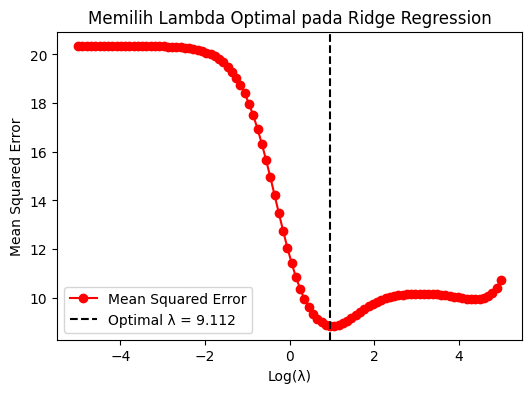

Nilai Lambda Optimal: 9.112


In [20]:
# Mencari nilai lambda terbaik
# Definisikan range nilai lambda (diubah ke skala log)
alphas = np.logspace(-5, 5, 100)  

# Ridge Regression dengan Cross-Validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)  
ridge_cv.fit(X_train_ols, y_train)

# Ambil nilai lambda terbaik
best_lambda = ridge_cv.alpha_

# Plot MSE vs log(lambda)
plt.figure(figsize=(6, 4))
plt.plot(np.log10(alphas), np.mean(ridge_cv.cv_values_, axis=0), 'o-', color='red', label="Mean Squared Error")
plt.axvline(np.log10(best_lambda), color='black', linestyle='--', label=f"Optimal λ = {best_lambda:.3f}")
plt.xlabel("Log(λ)")
plt.ylabel("Mean Squared Error")
plt.title("Memilih Lambda Optimal pada Ridge Regression")
plt.legend()
plt.show()

# Cetak nilai lambda terbaik
print(f"Nilai Lambda Optimal: {best_lambda:.3f}")

In [21]:
# Apply lambda terbaik ke model Ridge
# Inisialisasi model Ridge Regression dengan alpha (lambda) tertentu
ridge_model = Ridge(alpha=best_lambda)  

# Cetak hasil koefisien Ridge dan OLS
print(ridge_coeffs.to_string(index=False))

Variable  Coefficient Ridge  Coefficient OLS
   const           0.194600        -5.593700
     cyl          -0.020028        -0.476250
    disp           0.000126         0.018311
      hp          -0.012074        -0.009500
    drat           1.466613         1.002130
      wt          -2.275968        -4.862037
    qsec           1.081720         1.840952
      vs          -0.396993        -1.937186
      am           1.036119         1.076624
    gear           1.472484         1.327108
    carb          -0.473988         0.147131


### Regulariasi Regresi Lasso (L1)

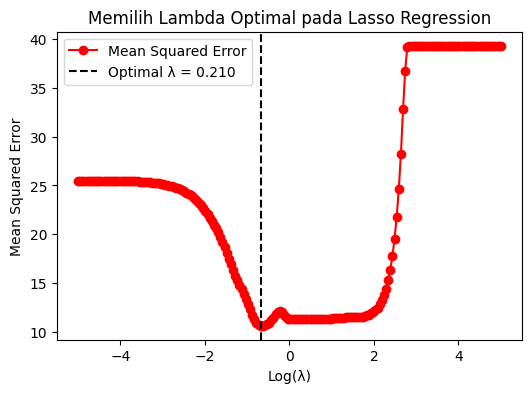

Nilai Lambda Optimal: 0.210


In [22]:
# Mencari nilai lambda terbaik
# Definisikan range nilai lambda (diubah ke skala log)
alphas = np.logspace(-5, 5, 200)  

# Lasso Regression dengan Cross-Validation
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42)  
lasso_cv.fit(X_train_ols, y_train)

# Ambil nilai lambda terbaik
best_lambda_lasso = lasso_cv.alpha_

# Plot MSE vs log(lambda)
plt.figure(figsize=(6, 4))
plt.plot(np.log10(lasso_cv.alphas_), np.mean(lasso_cv.mse_path_, axis=1), 'o-', color='red', label="Mean Squared Error")
plt.axvline(np.log10(best_lambda_lasso), color='black', linestyle='--', label=f"Optimal λ = {best_lambda_lasso:.3f}")
plt.xlabel("Log(λ)")
plt.ylabel("Mean Squared Error")
plt.title("Memilih Lambda Optimal pada Lasso Regression")
plt.legend()
plt.show()

# Cetak nilai lambda terbaik
print(f"Nilai Lambda Optimal: {best_lambda_lasso:.3f}")

In [23]:
# Inisialisasi model Lasso Regression dengan alpha (lambda) 
lasso_model = Lasso(alpha=best_lambda_lasso)  

# Latih model dengan data training
lasso_model.fit(X_train_ols, y_train)

# Buat DataFrame untuk menampilkan hasil 
lasso_coeffs = pd.DataFrame({
    'Variable': X_train_ols.columns,
    'Coefficient LASSO': lasso_model.coef_,  # Ridge coefficients
    'Coefficient OLS' : ols_model.params.values  # OLS coefficients
})

# Cetak hasil koefisien Ridge dan OLS
print(lasso_coeffs.to_string(index=False))

Variable  Coefficient LASSO  Coefficient OLS
   const           0.000000        -5.593700
     cyl          -0.682475        -0.476250
    disp          -0.003622         0.018311
      hp          -0.025435        -0.009500
    drat           0.000000         1.002130
      wt          -2.325504        -4.862037
    qsec           0.000000         1.840952
      vs           0.000000        -1.937186
      am           0.000000         1.076624
    gear           0.400402         1.327108
    carb          -0.000000         0.147131


### Bandingkan ke 4 Model

In [24]:
# Fungsi untuk menghitung MSE
def calculate_mse(model, X_train, X_test, y_train, y_test):
    """Menghitung MSE untuk train dan test set."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    return mse_train, mse_test

# Dictionary untuk menyimpan model dan hasil MSE
models = {}

# ===== REGRESI OLS =====
models["OLS"] = ols_model
mse_train_ols, mse_test_ols = calculate_mse(ols_model, X_train_ols, X_test_ols, y_train, y_test)

# ===== REGRESI STEPWISE (BACKWARD) =====
selected_features = [f for f in final_ols_model.params.index if f in X_train.columns]
X_train_stepwise = sm.add_constant(X_train[selected_features])
X_test_stepwise = sm.add_constant(X_test[selected_features])

models["Stepwise"] = final_ols_model
mse_train_stepwise, mse_test_stepwise = calculate_mse(final_ols_model, X_train_stepwise, X_test_stepwise, y_train, y_test)

# ===== REGRESI RIDGE & LASSO =====
for model_name, model in [("Ridge", ridge_cv), ("Lasso", lasso_cv)]:
    models[model_name] = model
    mse_train, mse_test = calculate_mse(model, X_train_ols, X_test_ols, y_train, y_test)
    exec(f"mse_train_{model_name.lower()} = mse_train")
    exec(f"mse_test_{model_name.lower()} = mse_test")

# ===== CETAK HASIL =====
print("Perbandingan MSE Model\n")
for name in models.keys():
    train_mse = eval(f"mse_train_{name.lower()}")
    test_mse = eval(f"mse_test_{name.lower()}")
    print(f"{name} - MSE Train: {train_mse:.3f}, MSE Test: {test_mse:.3f}")


Perbandingan MSE Model

OLS - MSE Train: 4.226, MSE Test: 10.130
Stepwise - MSE Train: 5.770, MSE Test: 7.700
Ridge - MSE Train: 5.478, MSE Test: 8.097
Lasso - MSE Train: 5.223, MSE Test: 7.986


In [25]:
# Buat DataFrame untuk membandingkan hasil prediksi dari keempat model
comparison_df = pd.DataFrame({
    "Model": df['model'],
    "y_actual": y_test.values,
    "ols_pred": ols_model.predict(X_test_ols),
    "ridge_pred": ridge_cv.predict(X_test_ols),
    "lasso_pred": lasso_cv.predict(X_test_ols),
    "stepwise_pred": final_ols_model.predict(X_test_stepwise)
}, index=X_test.index)  # Menggunakan index mobil dari X_test

# Cetak hasil
print(comparison_df)


                  Model  y_actual   ols_pred  ridge_pred  lasso_pred  \
29         Ferrari Dino      19.7  19.830927   20.480975   21.122265   
15  Lincoln Continental      10.4  10.987142   11.071545   10.626237   
24     Pontiac Firebird      19.2  16.314021   15.285024   15.532939   
17             Fiat 128      32.4  27.145907   26.877738   26.424918   
8              Merc 230      22.8  28.613212   22.941898   23.253137   
9              Merc 280      19.2  18.301333   20.596295   20.404536   
30        Maserati Bora      15.0  14.882511   12.202148   13.262249   

    stepwise_pred  
29      19.759651  
15       8.673615  
24      15.869526  
17      26.535474  
8       25.124081  
9       19.138938  
30      14.844915  


### Persamaan OLS

In [26]:
ols_eq = f"ŷ = {ols_model.params[0]:.3f}"
for feature, coef in zip(X_train.columns, ols_model.params[1:]):
    ols_eq += f" + ({coef:.3f} * {feature})"
print("Persamaan OLS:\n", ols_eq)

Persamaan OLS:
 ŷ = -5.594 + (-0.476 * cyl) + (0.018 * disp) + (-0.010 * hp) + (1.002 * drat) + (-4.862 * wt) + (1.841 * qsec) + (-1.937 * vs) + (1.077 * am) + (1.327 * gear) + (0.147 * carb)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11236\2088154104.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ols_eq = f"ŷ = {ols_model.params[0]:.3f}"


### Persamaan Stepwise

In [27]:
stepwise_eq = f"ŷ = {final_ols_model.params[0]:.3f}"
for feature, coef in zip(X_train_stepwise.columns[1:], final_ols_model.params[1:]): 
    stepwise_eq += f" + ({coef:.3f} * {feature})"
print("Persamaan Stepwise:\n", stepwise_eq)

Persamaan Stepwise:
 ŷ = 18.466 + (-5.037 * wt) + (0.984 * qsec)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11236\1901483156.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stepwise_eq = f"ŷ = {final_ols_model.params[0]:.3f}"


### Persamaan Ridge

In [28]:
ridge_eq = f"ŷ = {ridge_model.intercept_:.3f}"
for feature, coef in zip(X_train.columns, ridge_model.coef_):
    ridge_eq += f" + ({coef:.3f} * {feature})"
print("Persamaan Ridge:\n", ridge_eq)

AttributeError: 'Ridge' object has no attribute 'intercept_'

### Persamaan LASSO

In [ ]:
lasso_eq = f"ŷ = {lasso_model.intercept_:.3f}"
for feature, coef in zip(X_train.columns, lasso_model.coef_):
    if coef != 0:  
        lasso_eq += f" + ({coef:.3f} * {feature})"
print("Persamaan LASSO:\n", lasso_eq)


Persamaan LASSO:
 ŷ = 34.633 + (-0.682 * disp) + (-0.004 * hp) + (-0.025 * drat) + (-2.326 * qsec) + (0.400 * carb)
